In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))


def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_test, y_test_pred), 3))
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

    


**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [3]:
TRAIN_DATASET_PATH = './data/course_project_train.csv'
TEST_DATASET_PATH = './data/course_project_test.csv'
SAMPLE_SUBMIT_PATH = './data/sample_submission.csv'

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

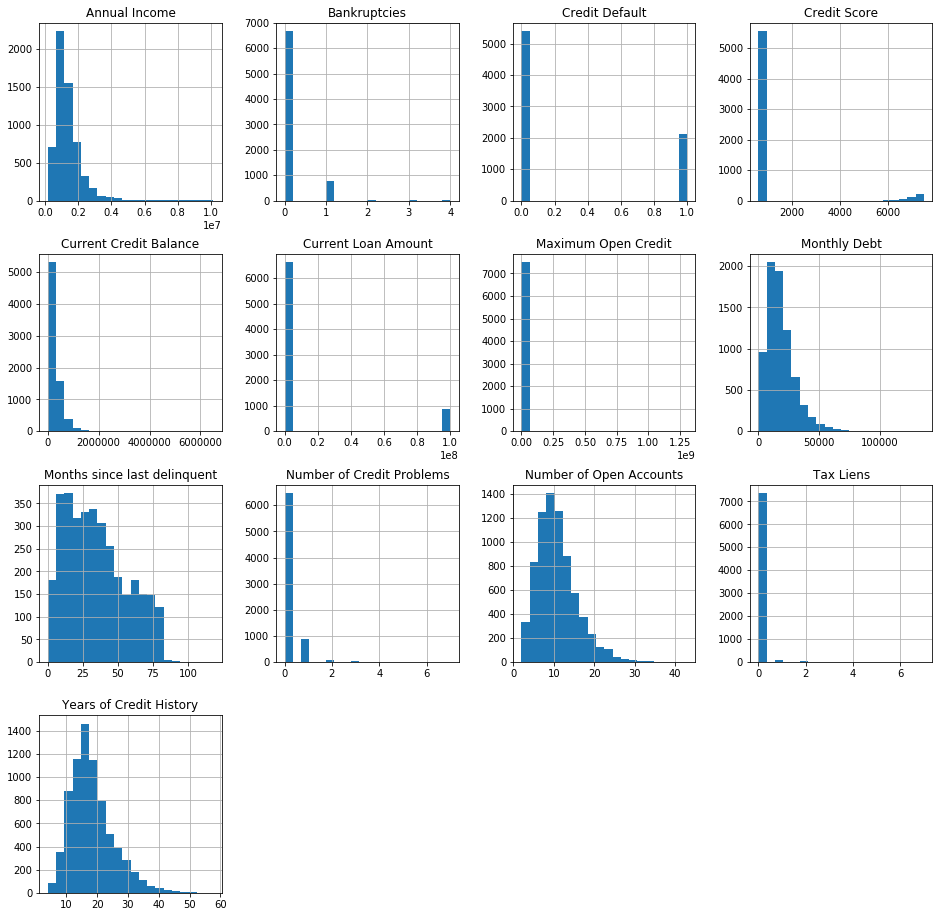

In [6]:
df_train.hist(bins = 20, figsize = (16, 16))
plt.show()

**Матрица корреляций**

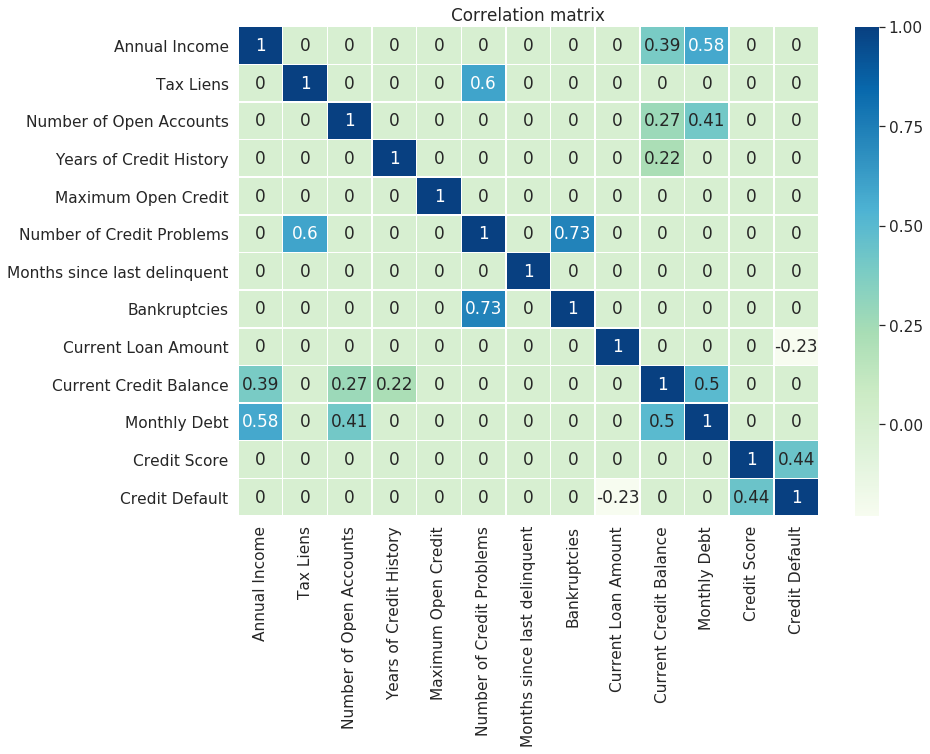

In [7]:
plt.figure(figsize=(13, 9))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [8]:
df_train.sample(10).T

,4607,5593,7133,2189,5720,6731,7089,332,5627,3461
Home Ownership,Home Mortgage,Home Mortgage,Rent,Home Mortgage,Home Mortgage,Rent,Rent,Rent,Rent,Rent
Annual Income,1.44938e+06,1.10261e+06,1.32158e+06,1.03892e+06,NaN,1.33914e+06,5.75928e+06,732906,836019,528789
Years in current job,10+ years,2 years,10+ years,NaN,10+ years,8 years,7 years,10+ years,1 year,2 years
Tax Liens,0,0,0,0,0,0,0,0,0,0
Number of Open Accounts,11,9,10,16,8,28,27,11,5,8
Years of Credit History,17.6,16.7,35.2,14.8,11.5,29.5,27.2,23.5,21.5,8
Maximum Open Credit,288662,945626,236456,664444,0,937904,3.93021e+06,509124,266464,452848
Number of Credit Problems,0,0,0,0,0,0,0,0,1,0
Months since last delinquent,6,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bankruptcies,0,0,0,0,0,0,0,0,1,0


In [9]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


**Класс обработки данных**

In [10]:
class DataPreparation:
    def __init__(self):
        """Границы, средние значения, медианы и моды"""
        self.annual_income_median = None
        
        self.years_in_curr_job_mode = None
        
        self.bankruptcies_median = None
        
        self.credit_score_median = None
        
    def meds_and_new_features(self, df):
        self.annual_income_median = df['Annual Income'].median()
        self.years_in_curr_job_mode = df['Years in current job'].mode()
        self.bankruptcies_median = df['Bankruptcies'].median()
        self.credit_score_median = df['Credit Score'].median()
    
    def prepare(self, df):
        # Обработка пропусков     
        df['Home Ownership'] = df['Home Ownership'].replace({'Home Mortgage': 0, 'Have Mortgage': 0, 'Rent': 1, 'Own Home': 2})        
        
        df['Years in current job'] = df['Years in current job'].replace(
            {'10+ years': 10,
             '2 years': 2,
             '3 years': 3,
             '< 1 year': 0,
             '5 years': 5,
             '1 year': 1,
             '4 years': 4,
             '6 years': 6,
             '7 years': 7,
             '8 years': 8,
             '9 years': 9})
        
        df['Term'] = df['Term'].replace({'Short Term': 0, 'Long Term': 1})        
        
        df.loc[df['Credit Score'] > 850, ['Credit Score']] = df['Credit Score'] // 10
        

    
        df['Annual Income'].fillna(self.annual_income_median, inplace = True)
        
        df['Years in current job'].fillna(self.annual_income_median, inplace = True)
        
        df['Bankruptcies'].fillna(self.bankruptcies_median, inplace = True)
        
        df['Credit Score'].fillna(self.credit_score_median, inplace=True)
        return df

**Отбор признаков**

In [11]:
features = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']
target = 'Credit Default'

**Подготовка данных**

In [12]:
data_prepare = DataPreparation()


In [13]:
data_prepare.meds_and_new_features(df_train)
df_train = data_prepare.prepare(df_train)
df_test = data_prepare.prepare(df_test)


**Разбиение на train и test**

In [14]:
y = df_train[target]
df_train = df_train[features]
df_test = df_test[features]


X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.33, random_state=21, stratify=y)

In [15]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5487288135593222

**Обучение модели**

In [16]:
model_catb = CatBoostClassifier(     
                                     silent=True, 
                                     random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=50,
                                     max_depth=7,
                                     min_data_in_leaf=5)

model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [17]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN
 0.549
TEST
 0.505
TRAIN

              precision    recall  f1-score   support

           0       0.87      0.59      0.70      3609
           1       0.42      0.78      0.55      1416

   micro avg       0.64      0.64      0.64      5025
   macro avg       0.65      0.68      0.63      5025
weighted avg       0.74      0.64      0.66      5025

TEST

              precision    recall  f1-score   support

           0       0.84      0.55      0.67      1778
           1       0.39      0.72      0.50       697

   micro avg       0.60      0.60      0.60      2475
   macro avg       0.61      0.64      0.59      2475
weighted avg       0.71      0.60      0.62      2475

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               985  793
1               194  503


**Важность признаков**

In [18]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                   columns=['feature_name', 'Importance'])

feature_importances.sort_values(by='Importance', ascending=False)

,feature_name,Importance
10,Current Loan Amount,40.447913
9,Term,16.982872
1,Annual Income,10.023468
13,Credit Score,9.539335
0,Home Ownership,4.497329
12,Monthly Debt,4.283580
11,Current Credit Balance,4.239174
5,Years of Credit History,3.424341
6,Maximum Open Credit,3.235292
4,Number of Open Accounts,1.635465


**Прогноз на тестовом датасете**

In [19]:
submit = pd.read_csv(SAMPLE_SUBMIT_PATH)

In [20]:
y_pred_final = model_catb.predict(df_test)

In [21]:
submit['Credit Default'] = y_pred_final
submit.to_csv('STolstov_predictions.csv', index=False)